In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
from capstone_library import *
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Hints
## Optimising Noisy Models
This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! you are trying to make the model’s log-likelihood as large as possible.

# Let's go!

Let's load the data.

In [2]:
X = np.load('initial_data/function_2/initial_inputs.npy')
y = np.load('initial_data/function_2/initial_outputs.npy')

In [3]:
# loading new data
new_queries = get_function_data_from_file('new_data/queries.txt', 2)
new_observ = get_function_data_from_file('new_data/observations.txt', 2)

In [4]:
# adding new_queries to X
new_queries = np.array(new_queries).reshape(-1, 2)
X = np.concatenate((X, new_queries), axis=0)

# adding new_observ to y
new_observ = np.array(new_observ).reshape(-1)
y = np.concatenate((y, new_observ), axis=0)

## Visualizing the data and thinking of the problem

In [5]:
# visualising the data as a table
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=['x1', 'x2', 'y'])
df.head(100)

,x1,x2,y
0,0.665800,0.123969,0.538996
1,0.877791,0.778628,0.420586
2,0.142699,0.349005,-0.065624
3,0.845275,0.711120,0.293993
4,0.454647,0.290455,0.214965
5,0.577713,0.771973,0.023106
6,0.438166,0.685018,0.244619
7,0.341750,0.028698,0.038749
8,0.338648,0.213867,-0.013858
9,0.702637,0.926564,0.611205


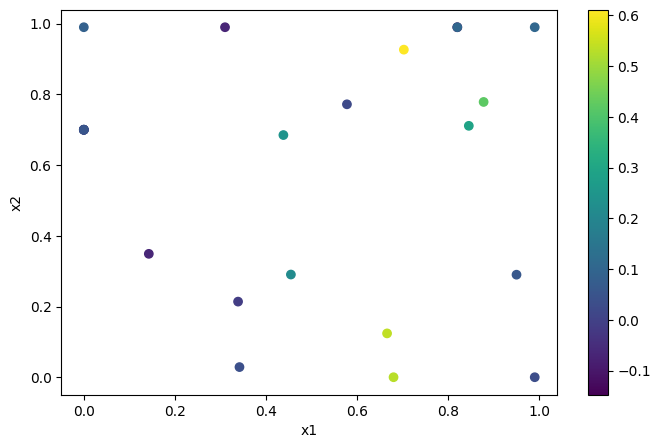

In [6]:
# visualising the data as a scatter plot
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Let's start with Bayesian Optimization with an Upper Confidence Bound acquisition function that uses a Gaussian Process as a surrogate model.

In [7]:
def get_next_query(grp, kappa, X, y):

    # to optimize the acquisition function, we will simply use gridsearch over a space of 10.000 gridpoints
    x1 = np.linspace(0, 1, 100, endpoint = False)
    x2 = np.linspace(0, 1, 100, endpoint = False)

    X_grid = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            X_grid.append([x1[i], x2[j]])

    X_grid = np.array(X_grid)
    mean, std = gpr.predict(X_grid, return_std = True)
    
    # plotting the standard deviation
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    plt.scatter(X_grid[:, 0], X_grid[:, 1], c = std)
    plt.scatter(X[:, 0], X[:, 1], c='red', marker='x')
    plt.colorbar()
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Standard Deviation')
    plt.show()

    # plotting the mean
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    plt.scatter(X_grid[:, 0], X_grid[:, 1], c = mean)
    plt.scatter(X[:, 0], X[:, 1], c='red', marker='x')
    plt.colorbar()
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Mean')
    plt.show()
    
    ucb = mean + kappa * std

    idx_max = np.argmax(ucb)
    next_query = X_grid[idx_max]
    return next_query, X_grid, ucb, mean, std


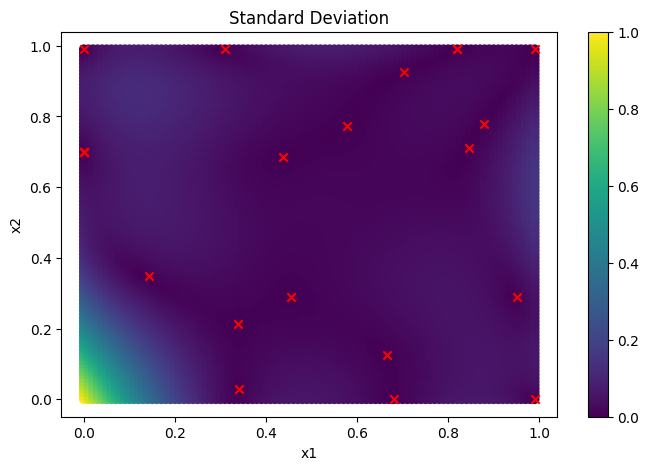

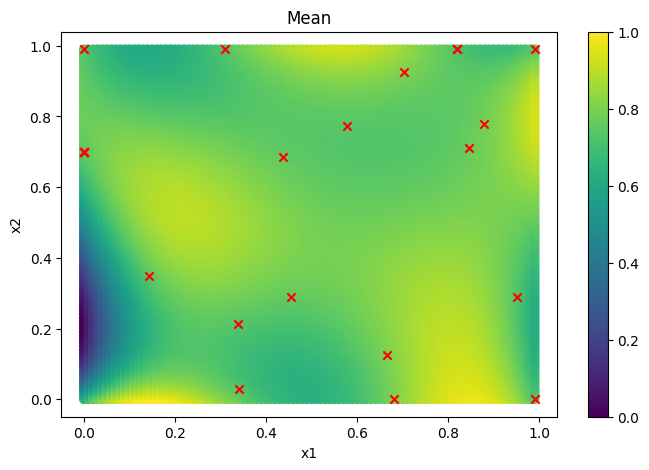

0.150000-0.000000


In [8]:
# getting the next query: higher kappa = more exploration, lower kappa = more exploitation
# parameters for the gaussian process
gpr = GaussianProcessRegressor()
gpr.fit(X, y)

next_query, X_grid, ucb, mean, std = get_next_query(gpr, 1, X, y)
print(format_query(next_query))


Not sure why the acquisition function is so high on the edge. Maybe it's because it's trying to stay away from the known minima while also getting explorative. 
Let's plot the acquisition function.

In [9]:
def plot_acquisition_function(X_grid, ucb, next_query=None):
    fig, ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    plt.scatter(X_grid[:, 0], X_grid[:, 1], c = ucb)
    plt.scatter(X[:, 0], X[:, 1], c='red', marker='x')
    if next_query is not None:
        plt.scatter(next_query[0], next_query[1], c = 'b', marker = 'x')
    plt.colorbar()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()

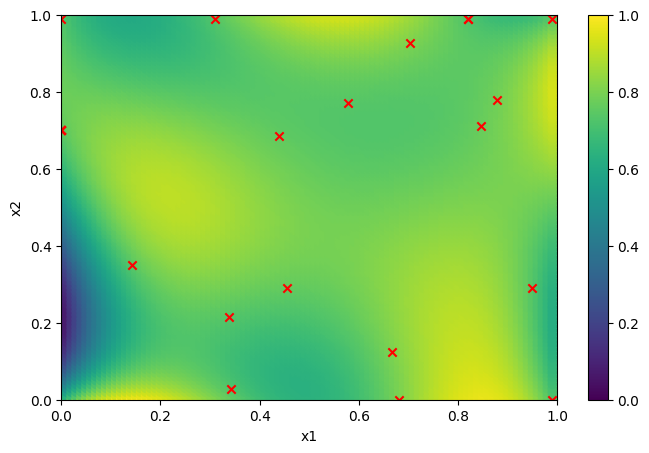

In [10]:
plot_acquisition_function(X_grid, ucb)

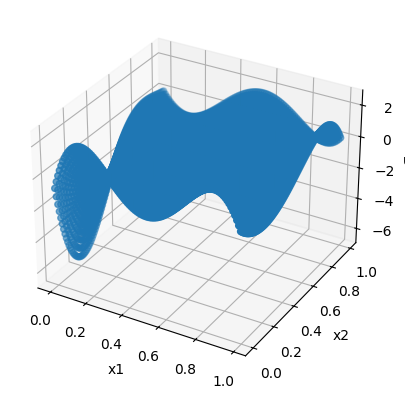

In [11]:
# plotting the acquisition function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_grid[:, 0], X_grid[:, 1], ucb)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('ucb')
plt.show()

### Observations with original data
By looking at the data, we can see that an area to be explored is indeed around [0, 1] as it is fairly unexplored.

### Observations after query 1
The first query was at [0, 0.99] due to the fact that the area was unexplored and we selected a high kappa. The query resulted in a low observation.
The second query is at another corner [0.99, 0.99]. That area is better explored than others, but has the local maximum.

### Observations after query 2
The second query was at the corner [0.99, 0.99] where the value is still low. The next suggested observation is at [0, 0.7], which is an area that is not explored at all.

Out of curiosity, let's see how the acquisition function changes if we add points at the suggested next_query, assuming that they do not strike gold.

### 20th query
Let's get more exploitative, kappa=1
0.820000-0.990000


### Observation after query 12

In [12]:
# let's look at the range of the standard deviation
print('min std:', np.min(std))
print('max std:', np.max(std))

# let's look at the range of the mean
print('min mean:', np.min(mean))
print('max mean:', np.max(mean))


min std: 4.472148552665697e-06
max std: 0.013883117113855247
min mean: -6.3318261303938925
max mean: 2.3098482750356197


It looks like the standard deviation is at most e-2, which means that the Gaussian Process is very confident about the model. We know, though, that there is noise in the function, as it is easy to observe that repeated queries return different values. Let's analyse the noise.

In [14]:
# let's isolate the repeated queries
# which queries are repeated?
unique, counts = np.unique(X, axis=0, return_counts=True)
repeated = unique[counts > 1]
print('repeated queries:', repeated)

# for each repeated query, get the min and max corresponding output, and the difference between them
for query in repeated:
    idx = np.where((X == query).all(axis=1))[0]
    outputs = y[idx]
    print('query:', query, 'min:', np.min(outputs), 'max:', np.max(outputs), 'diff:', np.max(outputs) - np.min(outputs))

repeated queries: [[0.   0.7 ]
 [0.82 0.99]]
query: [0.  0.7] min: -0.06616979285515211 max: 0.16558273113958843 diff: 0.23175252399474056
query: [0.82 0.99] min: -0.14741667028493033 max: 0.10345700400234395 diff: 0.25087367428727425


In [15]:
# range of the output
print('min output:', np.min(y))
print('max output:', np.max(y))

min output: -0.14741667028493033
max output: 0.6112052157614438


It looks like the potential noise is very high compared to the function values, so it is very likely that the Gaussian Process is not able to model the function well. Let's try to use a different kernel.

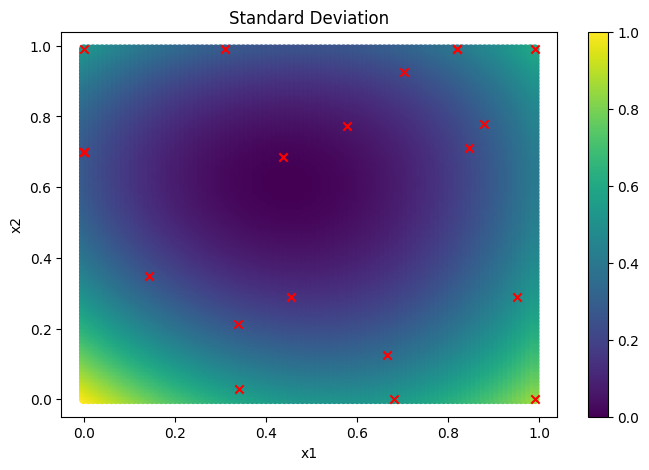

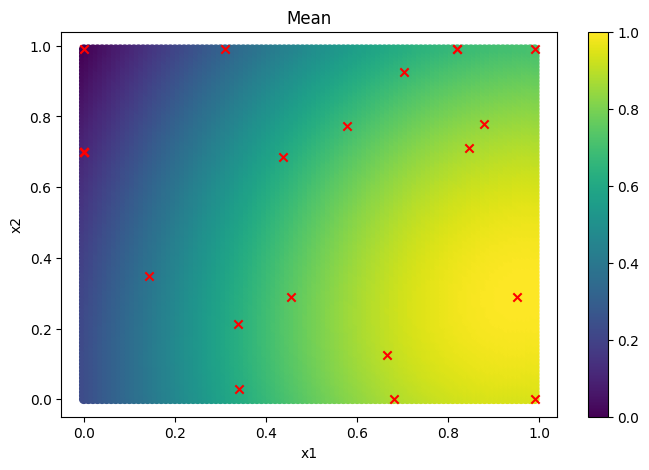

Next query: 0.990000-0.260000


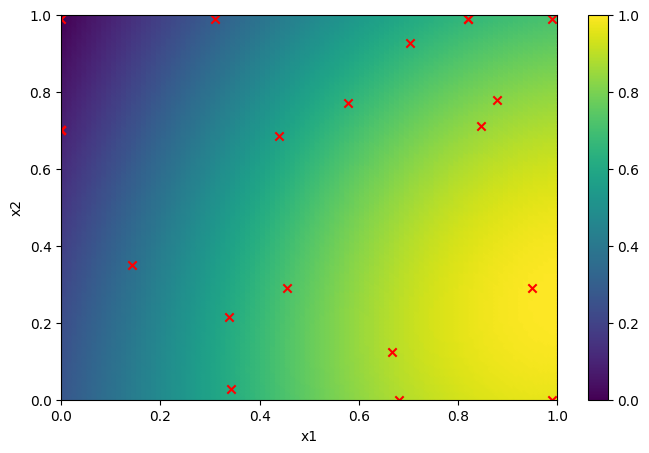

In [16]:
# let's tweak the Gaussian Process parameters to account for the noise observed so far: alpha = 0.25
# also, knowing that there may be many local optima, let's increase the number of restarts
# Initialize kernel with RBF and a WhiteKernel for noise

kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.25)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X, y)

next_query, X_grid, ucb, mean, std = get_next_query(gpr, 1, X, y)
print(f"Next query: {format_query(next_query)}")

plot_acquisition_function(X_grid, ucb)

Let's go with the suggested query above: 0.950000-0.290000

### After observation 23 (13th query)

Let's go with the suggested query: 0.950000-0.290000